<a href="https://colab.research.google.com/github/coding-cosmos/Sluice-Gate-Cavitation-Index/blob/main/notebooks/Sluice_Gate_Sensitivity_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sensitivity Analysis

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Utils

In [ ]:
# Install required packages
!pip install SALib pandas numpy matplotlib scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from SALib.sample import morris, saltelli
from SALib.analyze import morris as morris_analyze, sobol

In [ ]:
def morris_method(problem,model):
   # Perform Morris Sensitivity Analysis with model
    morris_samples = morris.sample(problem, N=1000, num_levels=4)
    y_morris = model.predict(morris_samples)
    morris_analysis = morris_analyze.analyze(problem, morris_samples, y_morris, num_levels=4)

    print("\nMorris Sensitivity Analysis Results (GBM):")
    for i, name in enumerate(problem['names']):
        print(f"{name}: Mu* = {morris_analysis['mu_star'][i]:.4f}, Sigma = {morris_analysis['sigma'][i]:.4f}")


    return morris_analysis


def sobol_method(problem,model):
  # Perform Sobol Sensitivity Analysis with GBM
    sobol_samples = saltelli.sample(problem, 1024)  # N should be a power of 2
    y_sobol = gbm_model.predict(sobol_samples)
    sobol_analysis = sobol.analyze(problem, y_sobol)

    print("\nSobol Sensitivity Analysis Results (GBM):")
    for i, name in enumerate(problem['names']):
        print(f"{name}: S1 = {sobol_analysis['S1'][i]:.4f}, ST = {sobol_analysis['ST'][i]:.4f}")

    return sobol_analysis




def sensitivity_analysis(problem,model):
    # Morris
    morris_analysis = morris_method(problem,model)

    # Sobol
    sobol_analysis = sobol_method(problem,model)


    # Print results
    print("GBM Feature Importances:")
    for name, importance in zip(problem['names'], gbm_model.feature_importances_):
        print(f"{name}: {importance:.4f}")



    # Plotting
    plt.figure(figsize=(15, 5))

    # GBM Feature Importance plot
    plt.subplot(131)
    importance_sorted_idx = np.argsort(gbm_model.feature_importances_)
    pos = np.arange(len(problem['names'])) + .5
    plt.barh(pos, gbm_model.feature_importances_[importance_sorted_idx])
    plt.yticks(pos, np.array(problem['names'])[importance_sorted_idx])
    plt.title("GBM Feature Importances")

    # Morris plot
    plt.subplot(132)
    plt.errorbar(range(len(problem['names'])), morris_analysis['mu_star'],
                yerr=morris_analysis['sigma'], fmt='o')
    plt.xticks(range(len(problem['names'])), problem['names'], rotation=45)
    plt.title("Morris Sensitivity Analysis (GBM)")
    plt.ylabel('Mu* (Mean of Elementary Effects)')

    # Sobol plot
    plt.subplot(133)
    x = range(len(problem['names']))
    width = 0.35
    plt.bar(x, sobol_analysis['S1'], width, label='First-order')
    plt.bar([i + width for i in x], sobol_analysis['ST'], width, label='Total-order')
    plt.xticks([i + width/2 for i in x], problem['names'], rotation=45)
    plt.title("Sobol Sensitivity Indices (GBM)")
    plt.legend()

    plt.tight_layout()
    plt.show()



## Dimensional

In [ ]:
# Load and prepare data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/dim.csv")  # Ensure this path is correct

# Select relevant columns
X = df[['AR', 'phi', 'L', 'Qw', 'Qa', 'Va', 'h','R']]
y = df['sigma']

# Scale the inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

 # Ensure valid bounds (avoiding identical min and max values)
bounds = []
for i in range(X_scaled.shape[1]):
    min_val, max_val = X_scaled[:, i].min(), X_scaled[:, i].max()
    if min_val == max_val:
        max_val += 1e-5  # Slightly adjust if needed
    bounds.append([min_val, max_val])

 # Define the problem for SALib
problem = {
    'num_vars': 8,
    'names': ['AR', 'phi', 'L', 'Qw', 'Qa', 'Va', 'h','R'],
    'bounds': bounds
}

In [ ]:
# Initialize GBM model
params_gbm_20 = {'n_estimators': 310, 'max_depth': 7, 'learning_rate': 0.10664589740085356, 'subsample': 0.6623650248841277, 'min_samples_split': 17, 'min_samples_leaf': 2, 'max_features': None}
gbm_model = GradientBoostingRegressor(
  **params_gbm_20
)

# Fit the GBM model
gbm_model.fit(X_scaled, y)

GradientBoostingRegressor(learning_rate=0.10664589740085356, max_depth=7,
                          min_samples_leaf=2, min_samples_split=17,
                          n_estimators=310, subsample=0.6623650248841277)


Morris Sensitivity Analysis Results (GBM):
AR: Mu* = 0.1995, Sigma = 0.2806
phi: Mu* = 2.3095, Sigma = 5.0771
L: Mu* = 0.7711, Sigma = 0.9596
Qw: Mu* = 25.3747, Sigma = 28.6969
Qa: Mu* = 8.2082, Sigma = 8.1296
Va: Mu* = 21.4609, Sigma = 24.1647
h: Mu* = 1.3400, Sigma = 1.7765
R: Mu* = 2.7727, Sigma = 5.8169


/tmp/ipython-input-14-2486256448.py:17: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  sobol_samples = saltelli.sample(problem, 1024)  # N should be a power of 2
/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))



Sobol Sensitivity Analysis Results (GBM):
AR: S1 = 0.0000, ST = 0.0007
phi: S1 = 0.0030, ST = 0.0075
L: S1 = -0.0014, ST = 0.0021
Qw: S1 = 0.1764, ST = 0.3190
Qa: S1 = 0.1248, ST = 0.1697
Va: S1 = 0.4243, ST = 0.5886
h: S1 = 0.0003, ST = 0.0020
R: S1 = 0.0046, ST = 0.0167
GBM Feature Importances:
AR: 0.0003
phi: 0.0387
L: 0.0006
Qw: 0.1615
Qa: 0.1578
Va: 0.5879
h: 0.0044
R: 0.0488


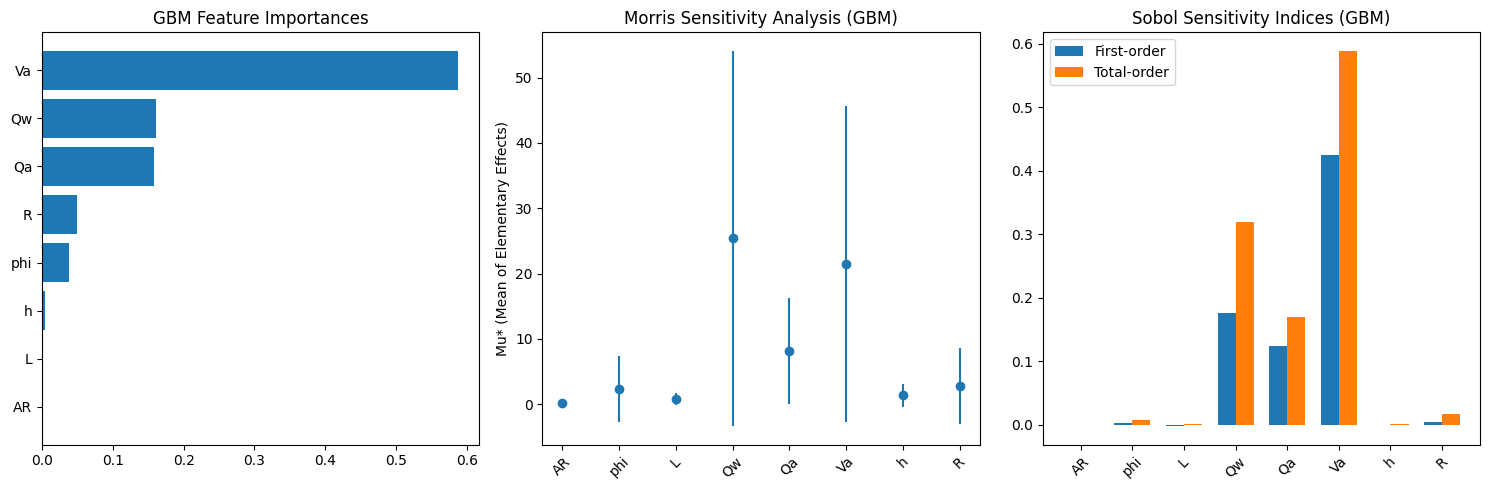

In [ ]:
sensitivity_analysis(problem,gbm_model)

## Non Dimensional

In [ ]:
# Load and prepare data
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/non_dim.csv")  # Ensure this path is correct

# Select relevant columns
X = df[['AR', 'phi', 'R/L', 'Fr', 'Qa/Qw']]
y = df['sigma']

# Scale the inputs
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

 # Ensure valid bounds (avoiding identical min and max values)
bounds = []
for i in range(X_scaled.shape[1]):
    min_val, max_val = X_scaled[:, i].min(), X_scaled[:, i].max()
    if min_val == max_val:
        max_val += 1e-5  # Slightly adjust if needed
    bounds.append([min_val, max_val])

 # Define the problem for SALib
problem = {
    'num_vars': 5,
    'names': ['AR', 'phi', 'R/L', 'Fr', 'Qa/Qw'],
    'bounds': bounds
}

In [ ]:
# Initialize GBM model
params_gbm_20 = {'n_estimators': 252, 'max_depth': 8, 'learning_rate': 0.06285652370947764, 'subsample': 0.8059737929229986, 'min_samples_split': 9, 'min_samples_leaf': 5, 'max_features': None}

gbm_model = GradientBoostingRegressor(
  **params_gbm_20
)

# Fit the GBM model
gbm_model.fit(X_scaled, y)

GradientBoostingRegressor(learning_rate=0.06285652370947764, max_depth=8,
                          min_samples_leaf=5, min_samples_split=9,
                          n_estimators=252, subsample=0.8059737929229986)


Morris Sensitivity Analysis Results (GBM):
AR: Mu* = 0.8304, Sigma = 1.0735
phi: Mu* = 7.0099, Sigma = 9.5066
R/L: Mu* = 0.3363, Sigma = 0.5062
Fr: Mu* = 78.5394, Sigma = 74.7806
Qa/Qw: Mu* = 6.5608, Sigma = 4.8783


/tmp/ipython-input-14-2486256448.py:17: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5.1 Please use `salib.sample.sobol`
  sobol_samples = saltelli.sample(problem, 1024)  # N should be a power of 2
/usr/local/lib/python3.11/dist-packages/SALib/util/__init__.py:274: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  names = list(pd.unique(groups))



Sobol Sensitivity Analysis Results (GBM):
AR: S1 = 0.0011, ST = 0.0016
phi: S1 = 0.0270, ST = 0.0671
R/L: S1 = -0.0004, ST = 0.0002
Fr: S1 = 0.9177, ST = 0.9638
Qa/Qw: S1 = 0.0208, ST = 0.0205
GBM Feature Importances:
AR: 0.0039
phi: 0.1055
R/L: 0.0010
Fr: 0.8819
Qa/Qw: 0.0078


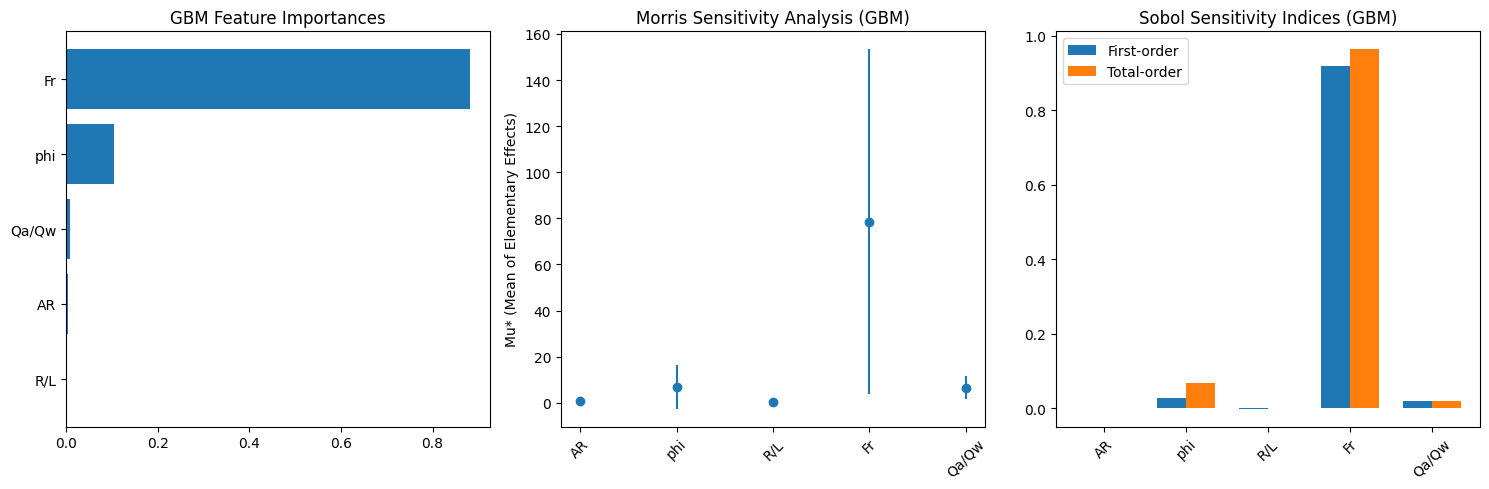

In [ ]:
sensitivity_analysis(problem,gbm_model)